In [1]:
#!/usr/bin/env python
# coding: utf-8

# #### Script to create time series of MSE and related variables from TC output
# 
# Assumes key integrated variables have been processed and written out by PE_write.py to single-level netcdf files.
# 
# James Ruppert  
# jruppert@ou.edu  
# 1/5/23

In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
import subprocess
import sys
# from mask_tc_track import mask_tc_track
import pandas as pd

In [3]:
# #### Main settings

# NOTE: Using copied tracking from CTL for NCRF tests

# #### Variable selection

storm = 'haiyan'
# storm = 'maria'

# How many members
nmem = 10 # number of ensemble members
nmem = 2

ptop = 100 # top for integrals; hPa

formula='vadv'#'hflux'#'converg'#

# TC tracking
# ptrack='600' # tracking pressure level
# var_track = 'rvor' # variable
# # rmax = 6 # radius (deg) limit for masking around TC center
# rmax = 3 # radius (deg) limit for masking around TC center

# Strat/Conv index subset
# istrat_all=[0,1,2] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil, (-1 for off)
nrain=6 # np.size(istrat_all)
# krain = 
    # 0 = conv+strat points
    # 1 = conv points
    # 2 = strat points
    # 3 = rainfall rate threshold
    # 4 = del . <sV> > 0
    # 5 = all points (inside of TC mask)

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/time_series/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"


def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift


# Tests to read and compare
ntest=2
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

In [4]:
# Ens member strings
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

# Get Lat/Lon
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
process = subprocess.Popen(['ls '+datdir+'/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
varfil_main.close()
lon1d=lon[0,:]
lat1d=lat[:,0]

datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/post/d02/'
fil = Dataset(datdir+'U.nc') # this opens the netcdf file
pres = fil.variables['pres'][:] # hPa
fil.close()
nk=np.size(pres)
iktop = np.where(pres == ptop)[0][0]

In [5]:
##### FUNCTIONS ############################################################

def var_read_3d_mse(datdir,varname,iktop):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][:,0:iktop+1,:,:]
    varfil_main.close()
    return var

def plot_rainhist(x):
    n, bins, patches = plt.hist(x, 500, density=True, facecolor='g', alpha=0.75)
    plt.xlabel('mm/hr')
    plt.ylabel('Occurrence')
    plt.title('Rainfall Rate Distribution')
    plt.xlim(0.1, 80)
    # plt.ylim(0, 0.03)
    # plt.grid(True)
    # plt.show()

def mask_edges(array):
    # Last dimensions of array must be x1,x2
    #   It is otherwise versatile
    buffer=80
    array = np.ma.array(array, mask=False, copy=True)
    array.mask[...,0:buffer,:]=True
    array.mask[...,-buffer:,:]=True
    array.mask[...,:,0:buffer]=True
    array.mask[...,:,-buffer:]=True
    # array = np.ma.filled(array, fill_value=np.nan)
    return array

In [6]:
# Create arrays

nt = np.zeros(ntest, dtype=np.int32)

for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()

    nt[itest]=i_nt

# Time index set based on TEST 0 (e.g., CTL)
gms_sav = np.empty((ntest,nmem,nrain,nt[0]))
dsecon_sav = np.empty((ntest,nmem,nrain,nt[0]))
msecon_sav = np.empty((ntest,nmem,nrain,nt[0]))
mf_ratio_sav = np.empty((ntest,nmem,nrain,nt[0]))
pe_mf_sav = np.empty((ntest,nmem,nrain,nt[0]))
pe_mp_sav = np.empty((ntest,nmem,nrain,nt[0]))
satfrac_sav = np.empty((ntest,nmem,nrain,nt[0]))

gms_sav[:]=np.nan
dsecon_sav[:]=np.nan
msecon_sav[:]=np.nan
mf_ratio_sav[:]=np.nan
pe_mf_sav[:]=np.nan
pe_mp_sav[:]=np.nan
satfrac_sav[:]=np.nan


# #### Main loop

for itest in range(ntest):
# for itest in range(1):

    print('Running test: ',tests[itest])

    for imemb in range(nmem):

        print('Running imemb: ',memb_all[imemb])

        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/'
        # track_file = datdir+'track_'+var_track+'_'+ptrack+'hPa.nc'
        # Localize to TC track
        # NOTE: Using copied tracking from CTL for NCRF tests
        # trackfil_ex=''
        # if 'ncrf' in tests[itest]:
        #     trackfil_ex='_ctlcopy'
        # track_file = datdir+'track_'+var_track+trackfil_ex+'_'+ptrack+'hPa.nc'

        # Read variables

        datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'

        # Strat
        varfil_main = Dataset(datdir+'strat.nc')
        strat = varfil_main.variables['strat'][:,0,:,:] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
        varfil_main.close()

        # Rain
        varfil_main = Dataset(datdir+'rainrate.nc')
        rain = varfil_main.variables['rainrate'][:,0,:,:]/24 # mm/d --> mm/hr
        varfil_main.close()

        # Main variables

        # Moist and dry static energy (MSE, DSE); saved up to 100 hPa
        varfil_main = Dataset(datdir+'mse.nc')
        # dse = varfil_main.variables['dse'][:,:,:,:] # J/kg, calculated as cpT + gz
        # mse = varfil_main.variables['mse'][:,:,:,:] # J/kg, calculated as cpT + gz + L_v*q
        if formula == 'vadv':
            grad_s = varfil_main.variables['grad_s_vadv'][:,:,:] # J/m^2/s
            grad_h = varfil_main.variables['grad_h_vadv'][:,:,:] # J/m^2/s
        elif formula == 'hflux':
            grad_s = varfil_main.variables['grad_s_hflux'][:,:,:] # J/m^2/s
            grad_h = varfil_main.variables['grad_h_hflux'][:,:,:] # J/m^2/s
        elif formula == 'converg':
            grad_s = varfil_main.variables['grad_s_converg'][:,:,:] # J/m^2/s
            grad_h = varfil_main.variables['grad_h_converg'][:,:,:] # J/m^2/s
        varfil_main.close()

        # PE variables
        varfil = Dataset(datdir+'precip_eff_vars.nc')
        vmfu = varfil.variables['vmfu'][:,0,:,:] # kg/m/s
        vmfd = varfil.variables['vmfd'][:,0,:,:] # kg/m/s
        condh = varfil.variables['condh'][:,0,:,:] # mm/d
        varfil.close()
        condh /= 24 # mm/d --> mm/hr

        # Saturation fraction
        varfil = Dataset(datdir+'satfrac.nc')
        pw = varfil.variables['pw'][:,0,:,:] # mm
        pws = varfil.variables['pw_sat'][:,0,:,:] # mm
        varfil.close()
        satfrac = pw/pws # %

        t0=0
        t1=nt[itest]

        # Mask out around TC center
        # rain = mask_tc_track(track_file, rmax, rain, lon, lat, t0, t1)
        # rain = np.ma.filled(rain, fill_value=np.nan)
        # strat = mask_tc_track(track_file, rmax, strat, lon, lat, t0, t1)
        # strat = np.ma.filled(strat, fill_value=np.nan)
        # grad_s = mask_tc_track(track_file, rmax, grad_s[:,np.newaxis,:,:], lon, lat, t0, t1)
        # grad_s = np.ma.filled(grad_s, fill_value=np.nan)
        # grad_h = mask_tc_track(track_file, rmax, grad_h[:,np.newaxis,:,:], lon, lat, t0, t1)
        # grad_h = np.ma.filled(grad_h, fill_value=np.nan)

        # Mask out domain-edges
        rain = mask_edges(rain)
        strat = mask_edges(strat)
        grad_s = mask_edges(grad_s)
        grad_h = mask_edges(grad_h)
        vmfu = mask_edges(vmfu)
        vmfd = mask_edges(vmfd)
        condh = mask_edges(condh)
        satfrac = mask_edges(satfrac)

        # Loop over time and average over specific points

        tshift = get_tshift(tests[itest])

        for it in range(nt[itest]):
            for krain in range(nrain):

                strat_it = strat[it]

                # conv+strat points
                if krain < 5:

                    if krain == 0:
                        ind_rain = ((strat_it == 1) | (strat_it == 2)).nonzero()
                    # conv points
                    elif krain == 1:
                        ind_rain = (strat_it == 1).nonzero()
                    # strat points
                    elif krain == 2:
                        ind_rain = (strat_it == 2).nonzero()
                    # rainfall rate threshold
                    elif krain == 3:
                        rain_thresh = 3. # mm/hr
                        ind_rain = (rain[it] >= rain_thresh).nonzero()
                    # Where del . <sV> > 0
                    elif krain == 4:
                        ind_rain = (grad_s[it] > 0).nonzero()

                    # Jump time step if too few points found
                    if np.size(ind_rain[0]) < 4: continue

                    grad_s_avg = np.nanmean(grad_s[it,ind_rain[0],ind_rain[1]])
                    grad_h_avg = np.nanmean(grad_h[it,ind_rain[0],ind_rain[1]])
                    rain_avg = np.nanmean(rain[it,ind_rain[0],ind_rain[1]])
                    condh_avg = np.nanmean(condh[it,ind_rain[0],ind_rain[1]])
                    vmfu_avg = np.nanmean(vmfu[it,ind_rain[0],ind_rain[1]])
                    vmfd_avg = np.nanmean(vmfd[it,ind_rain[0],ind_rain[1]])
                    satfrac_avg = np.nanmean(satfrac[it,ind_rain[0],ind_rain[1]])

                else:

                    grad_s_avg = np.nanmean(grad_s[it])
                    grad_h_avg = np.nanmean(grad_h[it])
                    rain_avg = np.nanmean(rain[it])
                    condh_avg = np.nanmean(condh[it])
                    vmfu_avg = np.nanmean(vmfu[it])
                    vmfd_avg = np.nanmean(vmfd[it])
                    satfrac_avg = np.nanmean(satfrac[it])

                gms = grad_h_avg / grad_s_avg

                mf_ratio = -1 * vmfd_avg / vmfu_avg
                pe_mf = 1 - mf_ratio
                pe_mp = rain_avg / condh_avg

                gms_sav[itest,imemb,krain,it+tshift] = gms
                dsecon_sav[itest,imemb,krain,it+tshift] = grad_s_avg
                msecon_sav[itest,imemb,krain,it+tshift] = grad_h_avg
                mf_ratio_sav[itest,imemb,krain,it+tshift] = mf_ratio
                pe_mf_sav[itest,imemb,krain,it+tshift] = pe_mf
                pe_mp_sav[itest,imemb,krain,it+tshift] = pe_mp
                satfrac_sav[itest,imemb,krain,it+tshift] = satfrac_avg

Running test:  ctl
Running imemb:  memb_01


/tmp/ipykernel_52141/2218891642.py:157: RuntimeWarning: Mean of empty slice
  vmfd_avg = np.nanmean(vmfd[it,ind_rain[0],ind_rain[1]])
/tmp/ipykernel_52141/2218891642.py:174: RuntimeWarning: invalid value encountered in true_divide
  pe_mp = rain_avg / condh_avg
/tmp/ipykernel_52141/2218891642.py:156: RuntimeWarning: Mean of empty slice
  vmfu_avg = np.nanmean(vmfu[it,ind_rain[0],ind_rain[1]])


Running imemb:  memb_02
Running test:  ncrf36h
Running imemb:  memb_01
Running imemb:  memb_02


/tmp/ipykernel_52141/1459506552.py:119: RuntimeWarning: Mean of empty slice
  mean_t0 = np.nanmean(var0, axis=0)
/home/jamesrup/miniconda3/envs/plotting/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_52141/1459506552.py:135: RuntimeWarning: Mean of empty slice
  mean_t1 = np.nanmean(var1, axis=0)


xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


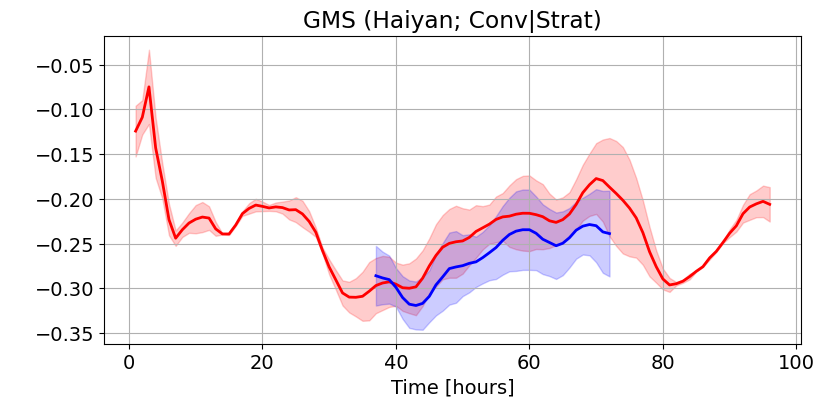

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


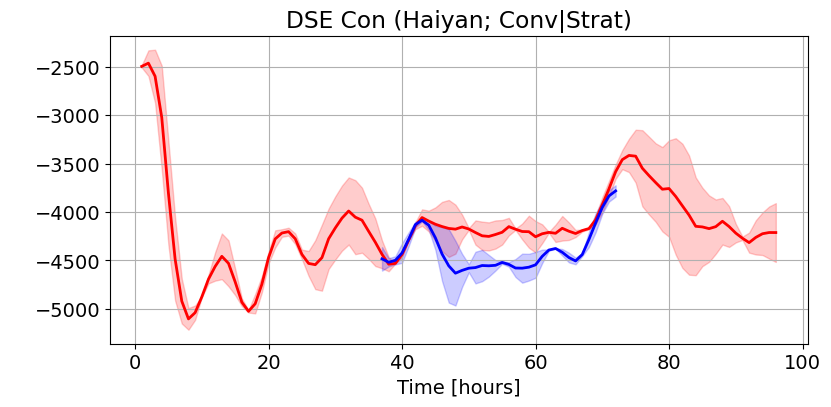

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


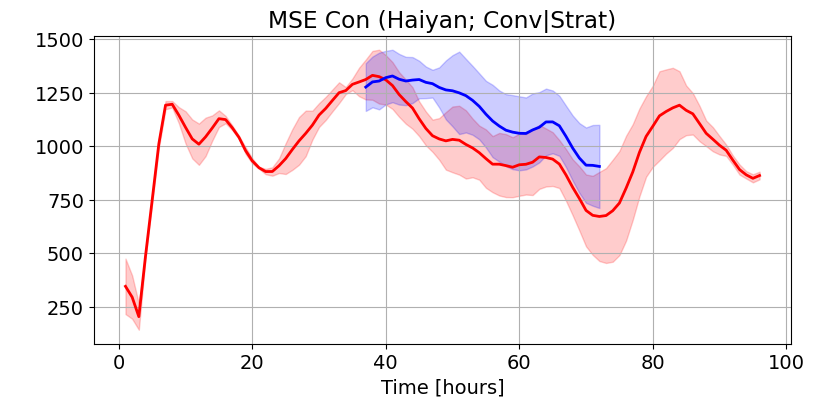

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


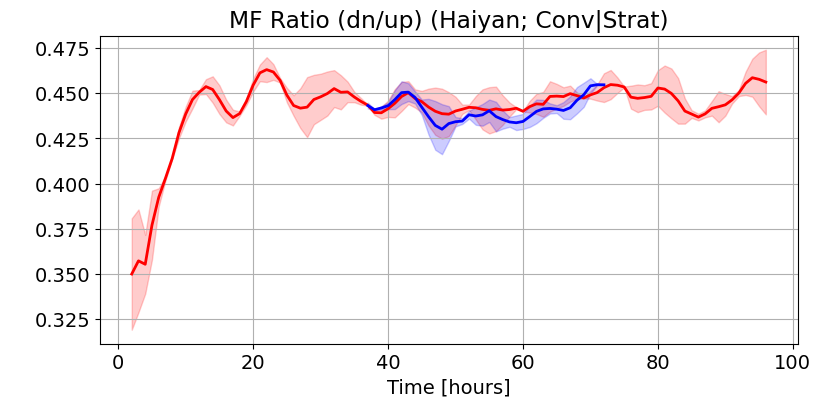

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


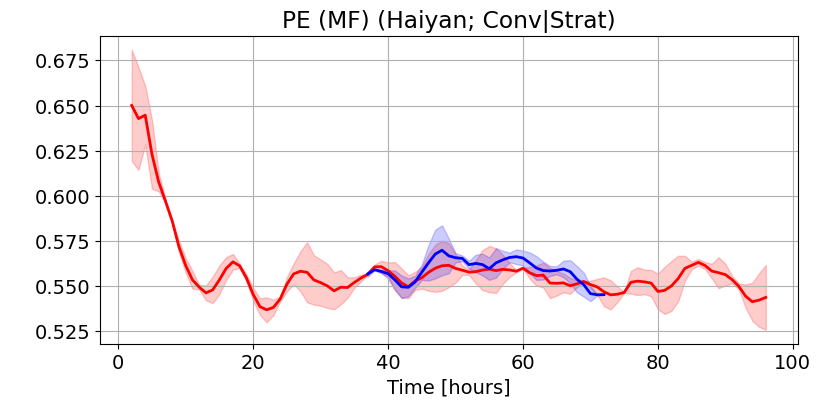

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


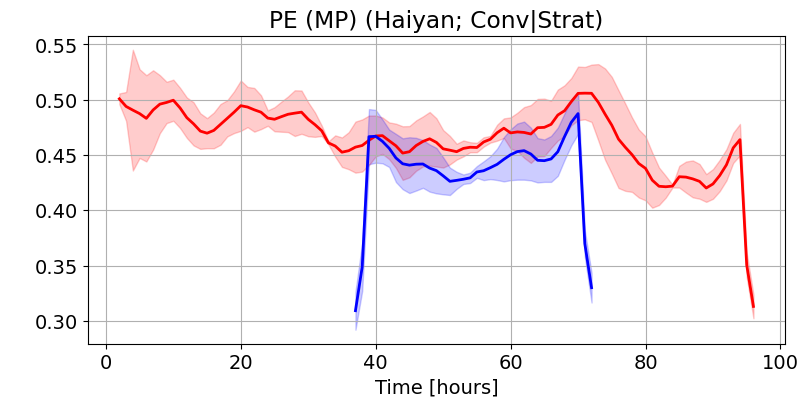

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


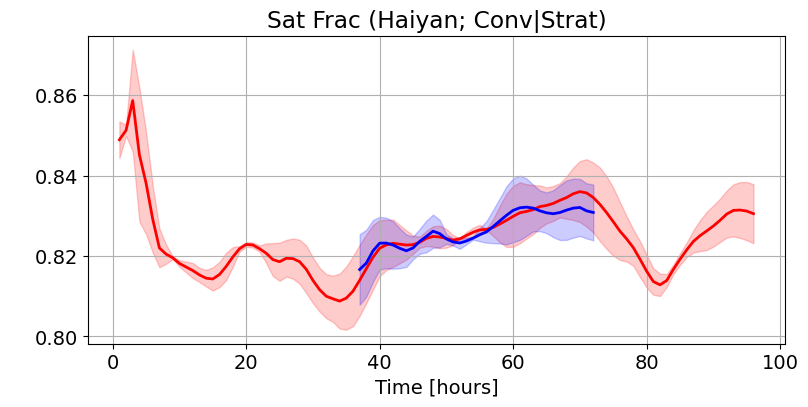

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


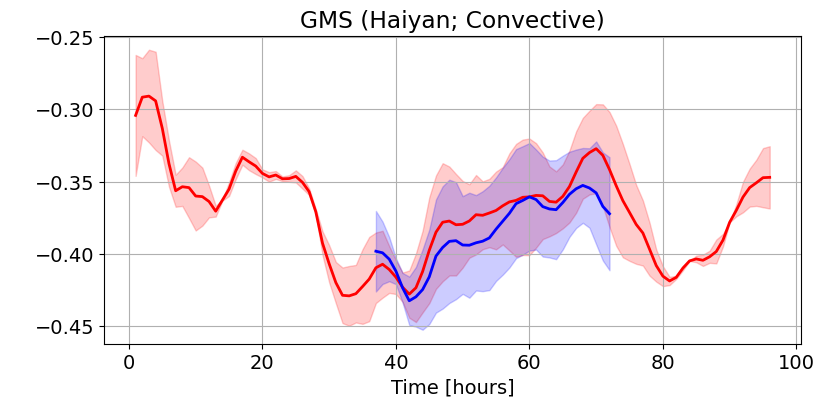

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


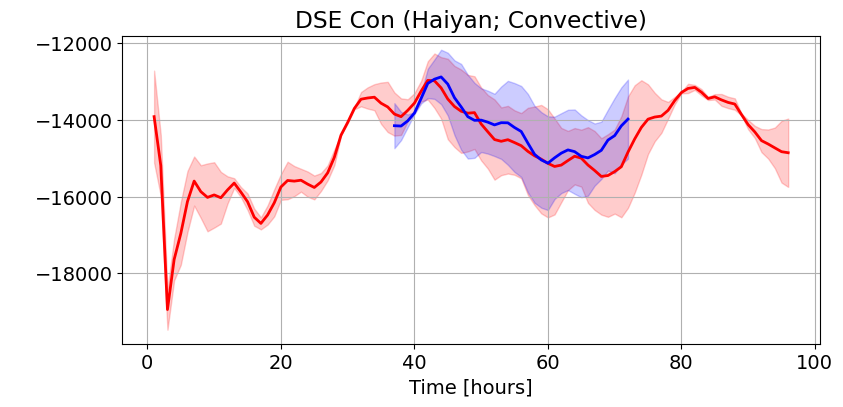

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


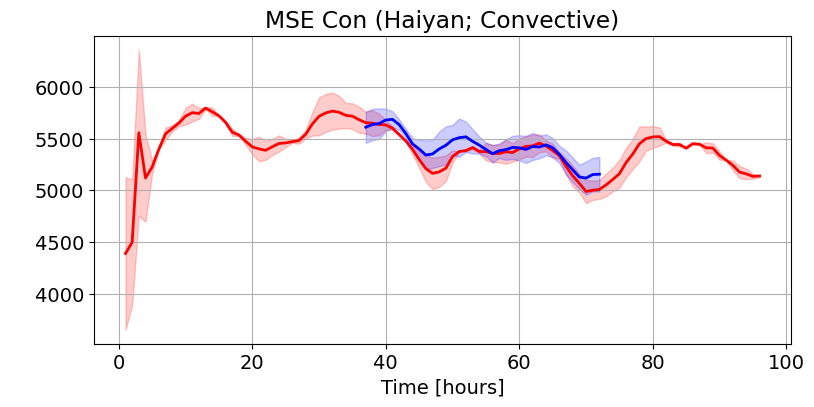

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


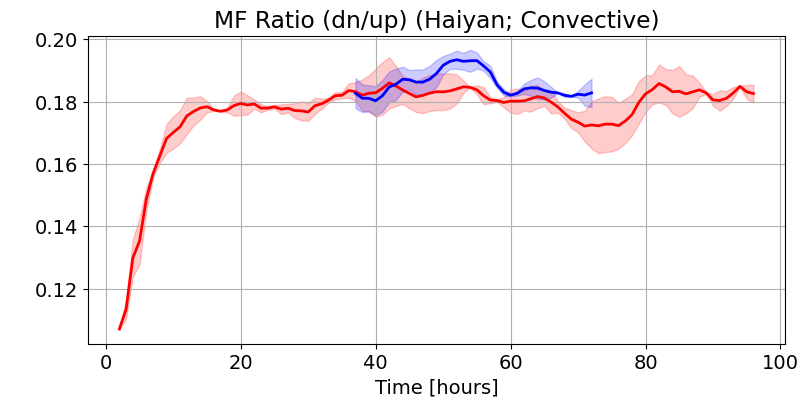

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


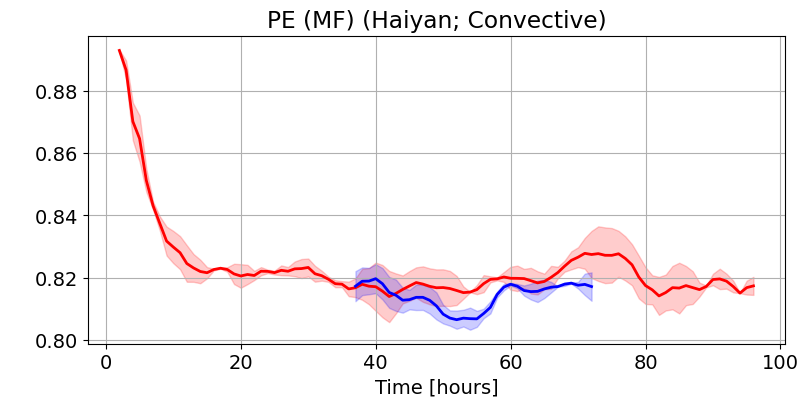

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


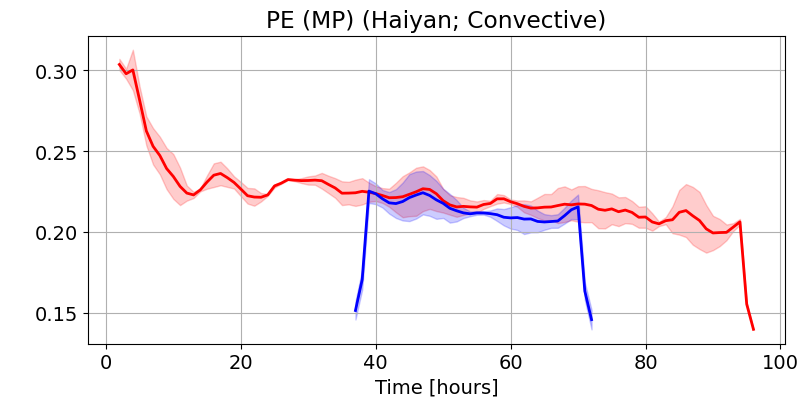

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


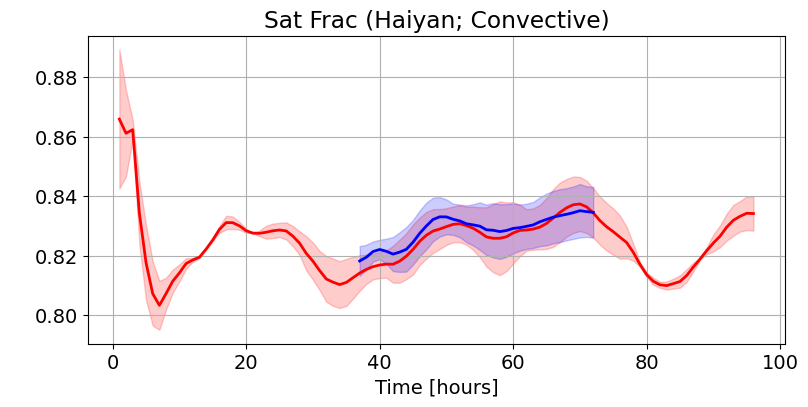

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


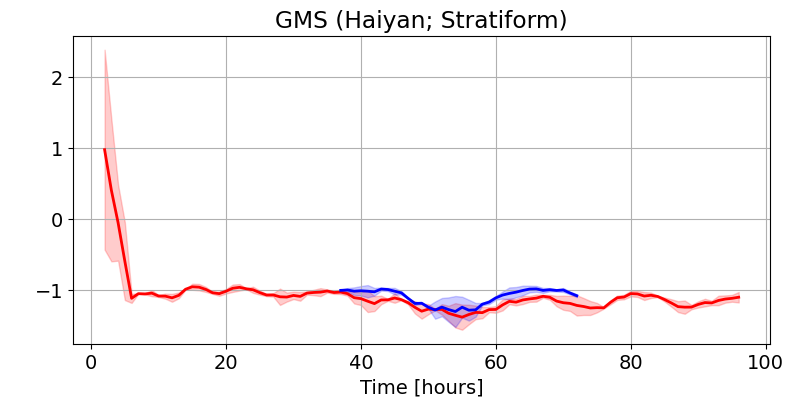

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


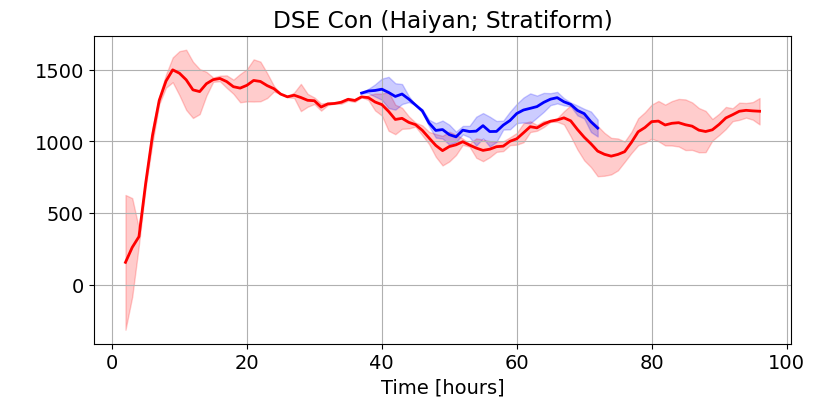

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


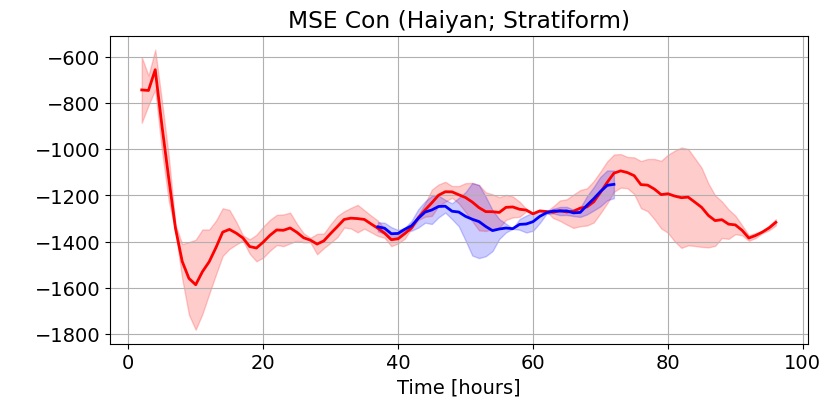

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


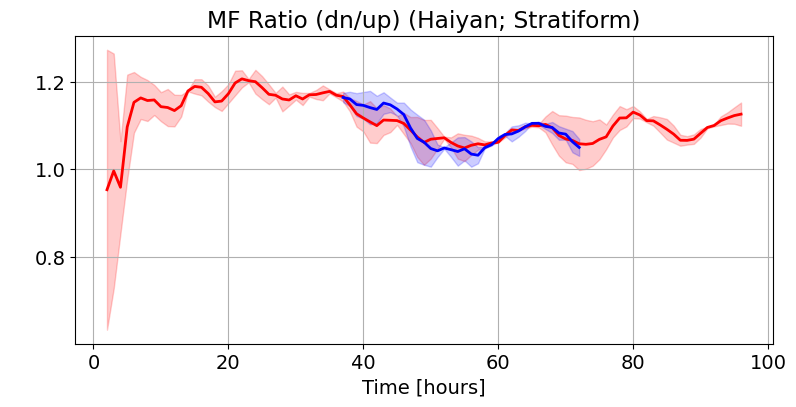

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


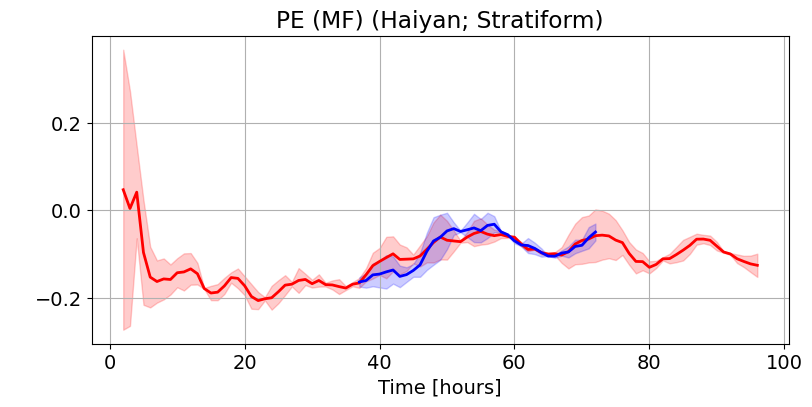

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


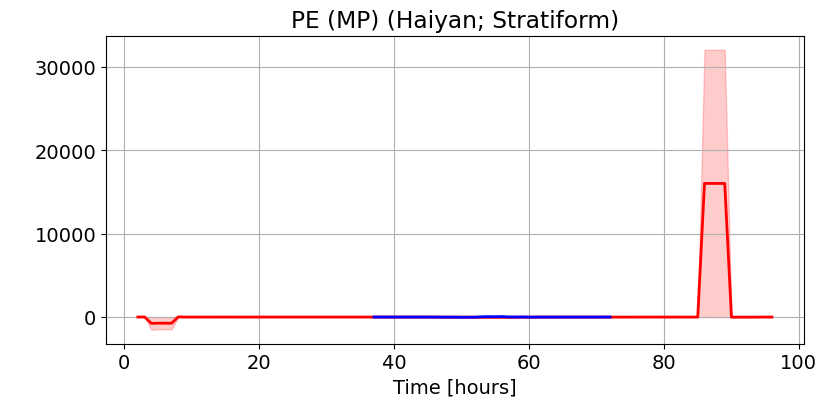

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


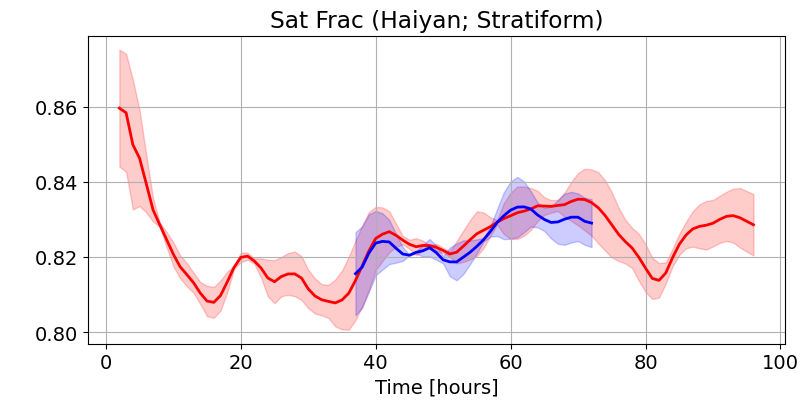

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


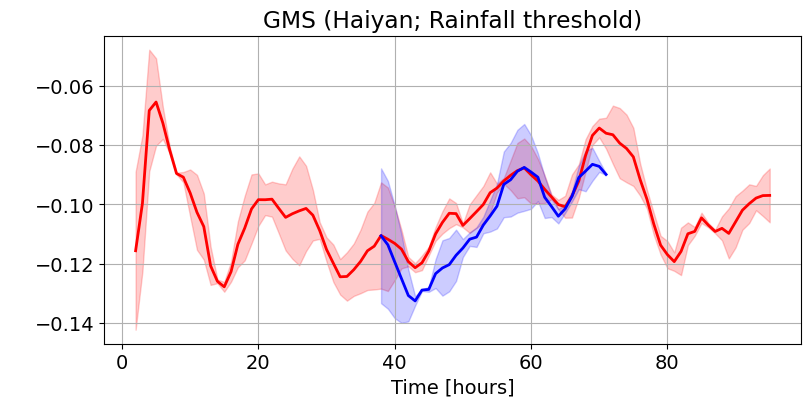

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


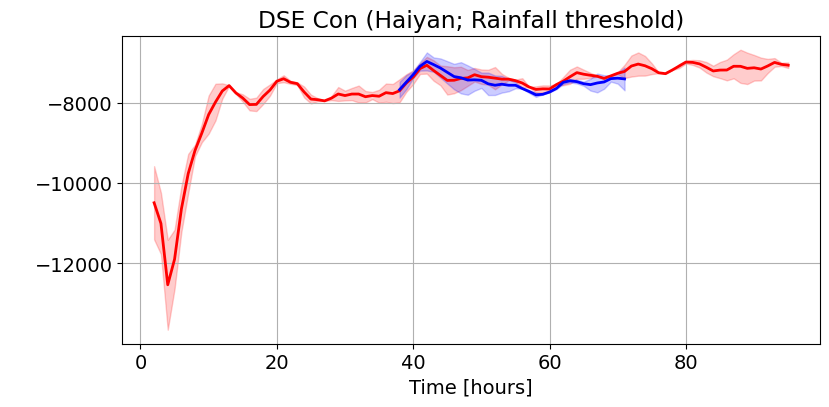

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


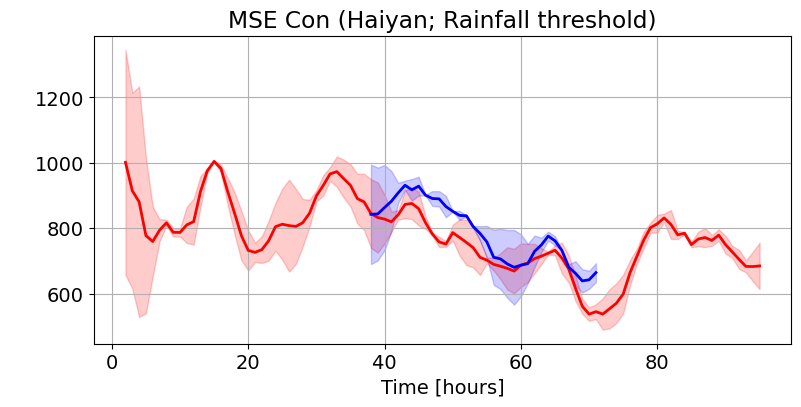

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


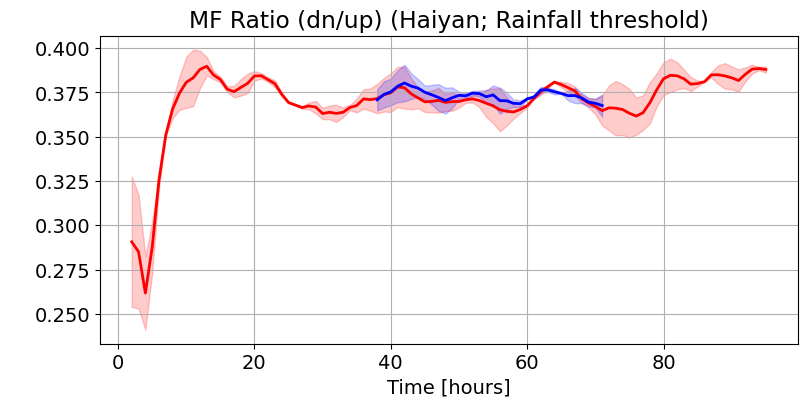

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


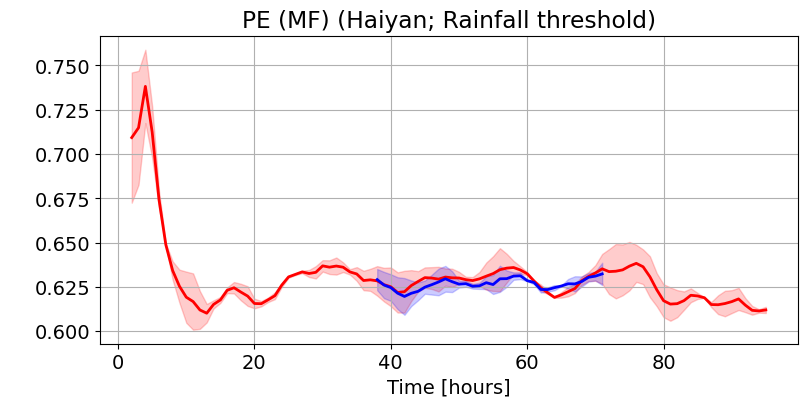

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


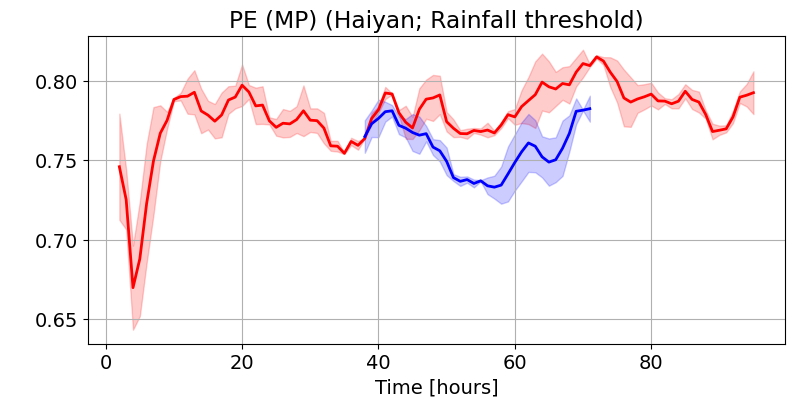

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


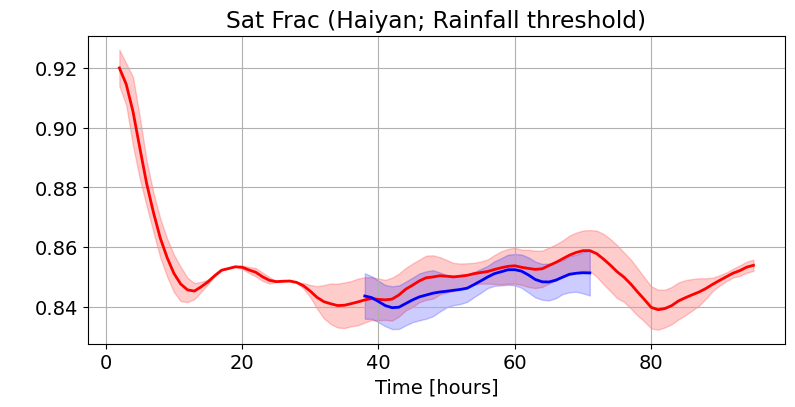

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


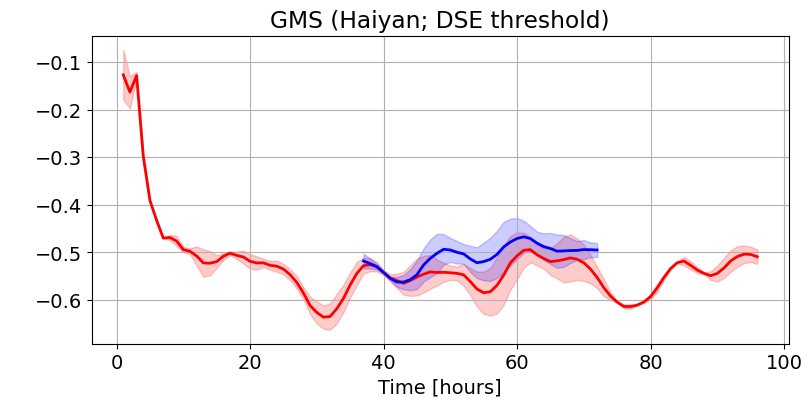

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


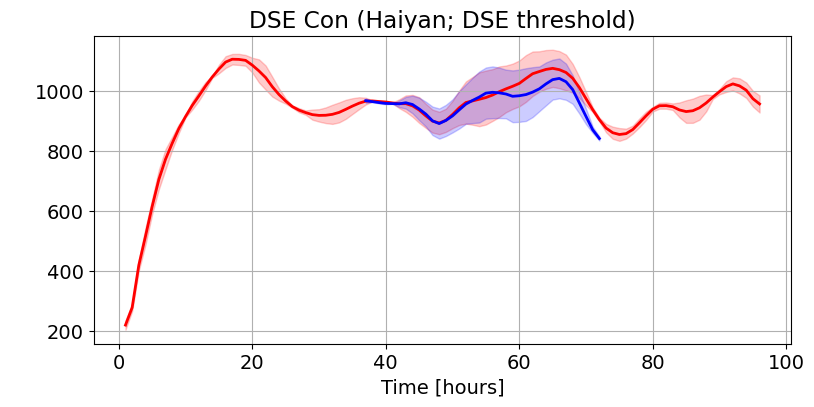

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


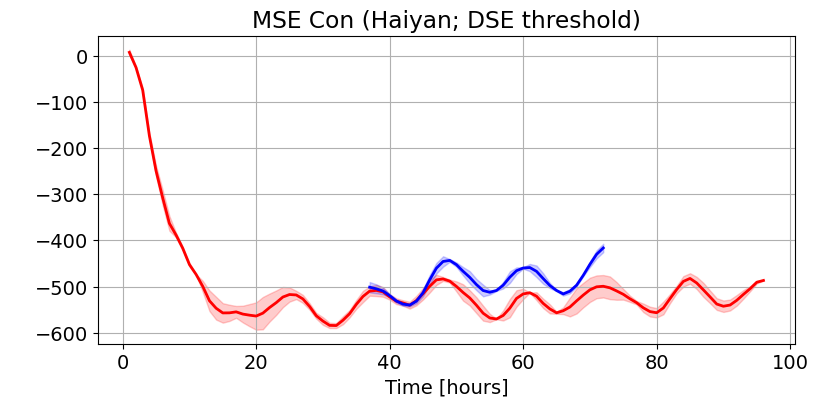

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


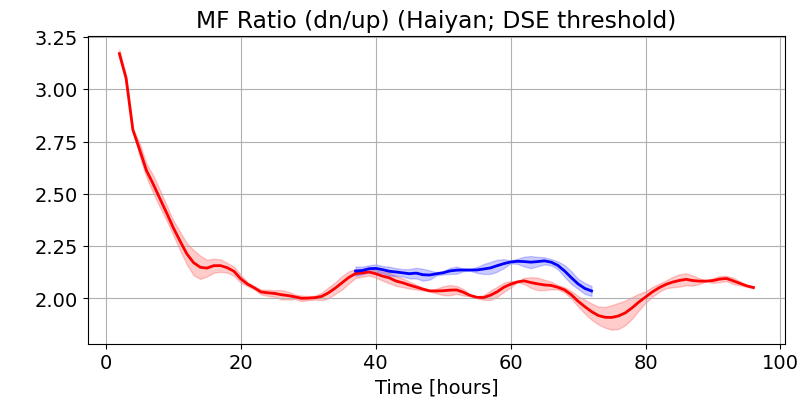

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


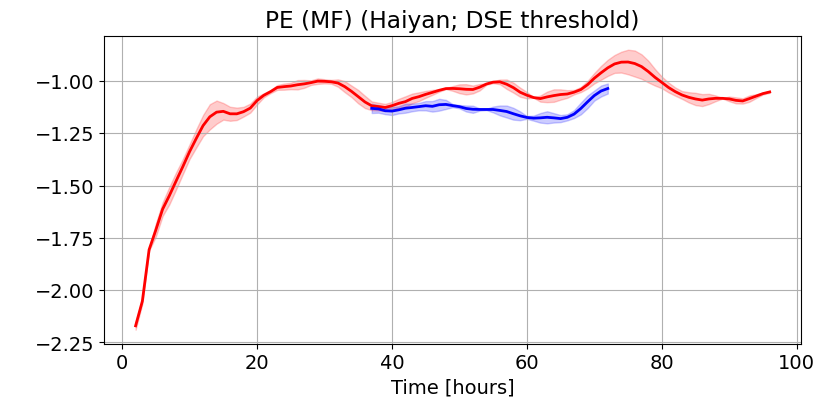

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


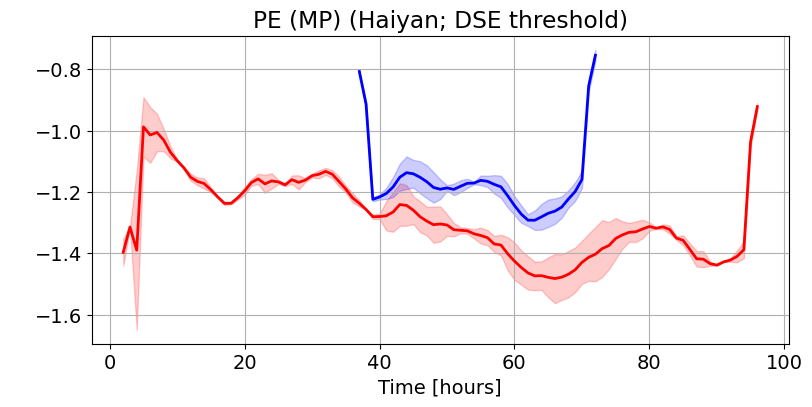

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


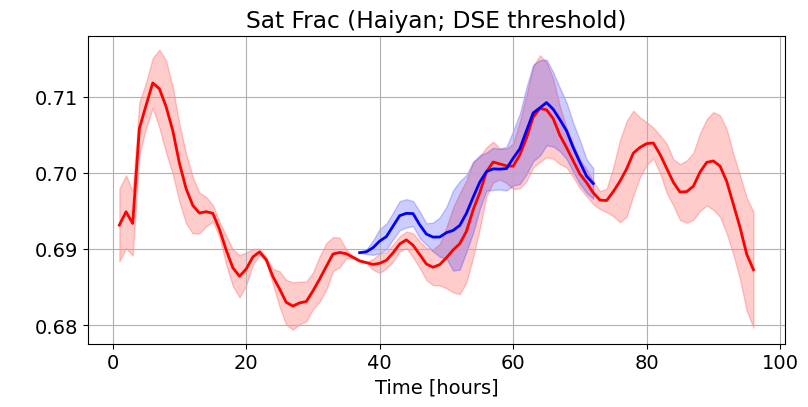

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


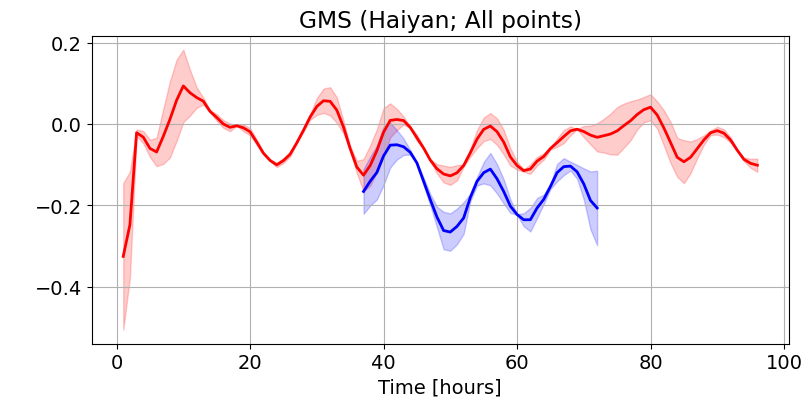

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


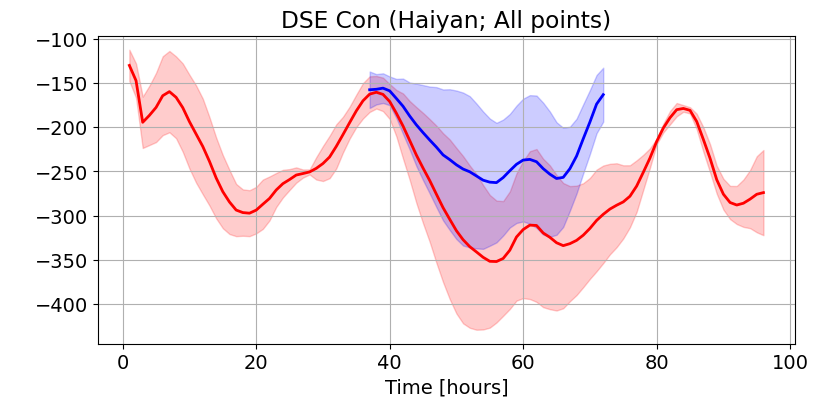

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


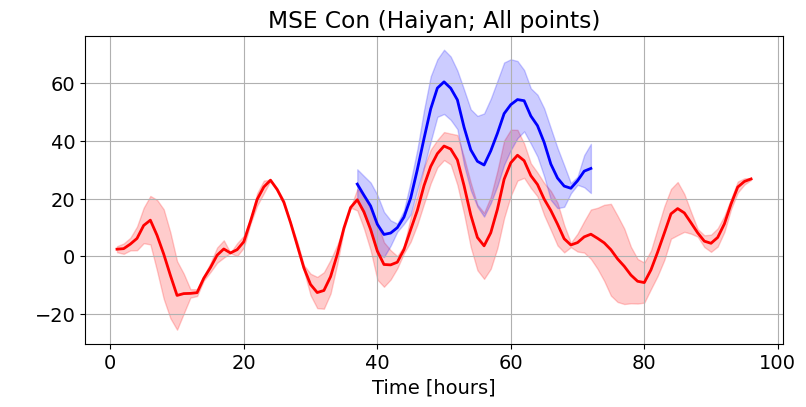

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


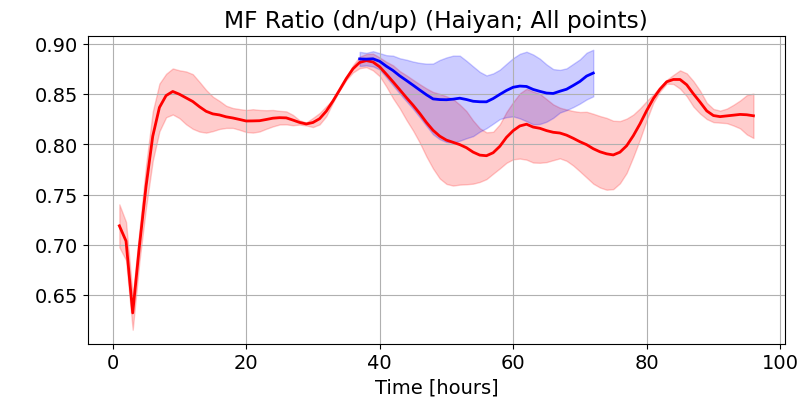

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


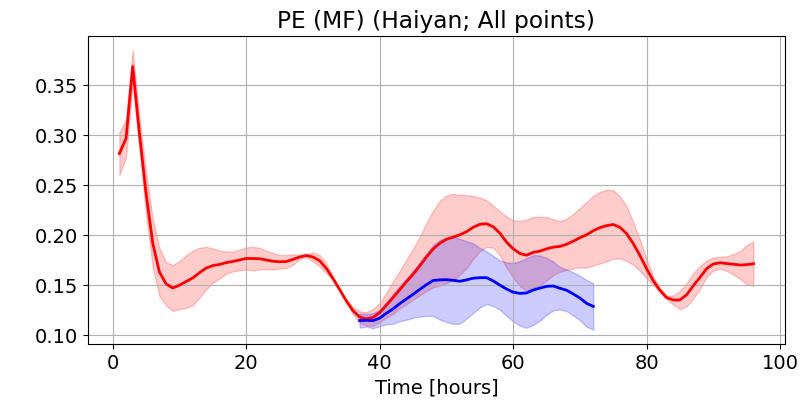

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


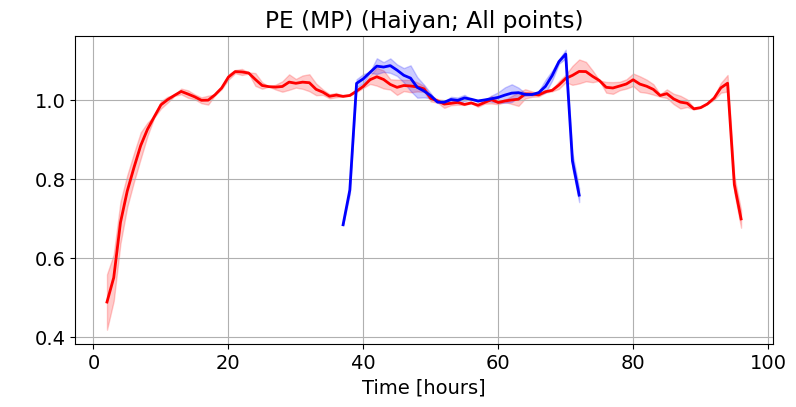

xdim:  range(0, 97)
meant0:  (97,)
xdim:  range(0, 97)
meant1:  (97,)


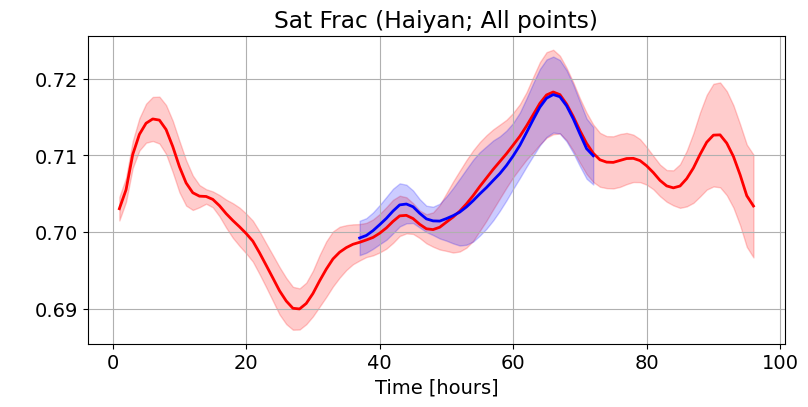

In [7]:
# ### Plotting routines

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


for krain in range(nrain):
# for krain in range(1):

    # conv+strat points
    if krain == 0:
        fig_extra='CS'
        raintag='Conv|Strat'
    # conv points
    elif krain == 1:
        fig_extra='conv'
        raintag='Convective'
    # strat points
    elif krain == 2:
        fig_extra='strat'
        raintag='Stratiform'
    # rainfall rate threshold
    elif krain == 3:
        fig_extra='rainthresh'
        raintag='Rainfall threshold'
    # rainfall rate threshold
    elif krain == 4:
        fig_extra='dsethresh'
        raintag='DSE threshold'
    elif krain == 5:
        fig_extra='all'
        raintag='All points'

    gms0 = gms_sav[0,:,krain,:]
    dse0 = dsecon_sav[0,:,krain,:]
    mse0 = msecon_sav[0,:,krain,:]
    mf0 = mf_ratio_sav[0,:,krain,:]
    pe_mf0 = pe_mf_sav[0,:,krain,:]
    pe_mp0 = pe_mp_sav[0,:,krain,:]
    satfrac0 = satfrac_sav[0,:,krain,:]

    gms1 = gms_sav[1,:,krain,:]
    dse1 = dsecon_sav[1,:,krain,:]
    mse1 = msecon_sav[1,:,krain,:]
    mf1 = mf_ratio_sav[1,:,krain,:]
    pe_mf1 = pe_mf_sav[1,:,krain,:]
    pe_mp1 = pe_mp_sav[1,:,krain,:]
    satfrac1 = satfrac_sav[1,:,krain,:]

    nvar=7
    for ivar in range(nvar):
    # for ivar in range(0,1):

        if ivar == 0:
            var0 = np.copy(gms0)
            var1 = np.copy(gms1)
            title_tag = 'GMS'
            figtag = 'gms-'+formula
        elif ivar == 1:
            var0 = np.copy(dse0)
            var1 = np.copy(dse1)
            title_tag = 'DSE Con'
            figtag = 'dsecon-'+formula
        elif ivar == 2:
            var0 = np.copy(mse0)
            var1 = np.copy(mse1)
            title_tag = 'MSE Con'
            figtag = 'msecon-'+formula
        if ivar == 3:
            var0 = np.copy(mf0)
            var1 = np.copy(mf1)
            title_tag = 'MF Ratio (dn/up)'
            figtag = 'mffrac'
        elif ivar == 4:
            var0 = np.copy(pe_mf0)
            var1 = np.copy(pe_mf1)
            title_tag = 'PE (MF)'
            figtag = 'pemf'
        elif ivar == 5:
            var0 = np.copy(pe_mp0)
            var1 = np.copy(pe_mp1)
            title_tag = 'PE (MP)'
            figtag = 'pemp'
        elif ivar == 6:
            var0 = np.copy(satfrac0)
            var1 = np.copy(satfrac1)
            title_tag = 'Sat Frac'
            figtag = 'satfrac'

    #----------------------------------------------------------------

        var0 = pd.DataFrame(var0)
        var0 = var0.rolling(window=3, center=True, closed='both', axis=1).mean()
        var0 = np.copy(var0)

        var1 = pd.DataFrame(var1)
        var1 = var1.rolling(window=3, center=True, closed='both', axis=1).mean()
        var1 = np.copy(var1)

        # create figure
        fig = plt.figure(figsize=(9,4))
        ax = fig.add_subplot(111)

        ax.set_title(title_tag+' ('+storm.capitalize()+'; '+raintag+')')#, fontsize=20)
        ax.set_ylabel(' ')
        ax.set_xlabel('Time [hours]')

        t_range=[30,80]
        # plt.xlim(t_range)

        color_t0 = 'red'
        color_t1 = 'blue'

        # Test 0

        mean_t0 = np.nanmean(var0, axis=0)
        std_t0 = np.nanstd(var0, axis=0)

        # tshift = get_tshift(tests[0])
        # xdim = range(0+tshift, nt[0]+tshift)
        xdim = range(nt[0])

        # for imemb in range(nmem):
        #     plt.plot(xdim, var0[imemb,:], linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
        print("xdim: ",xdim)
        print("meant0: ",mean_t0.shape)
        plt.plot(xdim, mean_t0, linewidth=2, label=tests[0].upper(), color=color_t0, linestyle='solid')
        plt.fill_between(xdim, mean_t0 + std_t0, mean_t0 - std_t0, alpha=0.2, color=color_t0)

        # Test 1

        mean_t1 = np.nanmean(var1, axis=0)
        std_t1 = np.nanstd(var1, axis=0)

        # tshift = get_tshift(tests[1])
        # xdim = range(0+tshift, nt[1]+tshift)

        # for imemb in range(nmem):
        #     plt.plot(xdim, var1[imemb,:], linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
        print("xdim: ",xdim)
        print("meant1: ",mean_t1.shape)
        plt.plot(xdim, mean_t1, linewidth=2, label=tests[0].upper(), color=color_t1, linestyle='solid')
        plt.fill_between(xdim, mean_t1 + std_t1, mean_t1 - std_t1, alpha=0.2, color=color_t1)

        plt.grid()

        # plt.legend(loc="upper right")

        # rmax_str = str(rmax)
        # figdir2 = figdir+rmax_str+'deg/'
        figdir2 = figdir+'all/'
        # figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'_rmax'+rmax_str+'deg.png'
        figname=figdir2+'tser_'+storm+'_'+figtag+'_'+fig_extra+'.png'
        plt.savefig(figname,dpi=200, facecolor='white', \
                    bbox_inches='tight', pad_inches=0.2)
        plt.show()
        plt.close()